https://github.com/ashleylizg/nlp-tutorial/blob/main/main.ipynb

used for reference

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
#% matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#% matplotlib inline

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/AmazonPantsData_Medium'

# Load Amazon reviews from CSV
start = time.time()
girl_pants = pd.read_csv('med_girl_pant.csv')
#boy_pants = pd.read_csv('med_boy_pant.csv')

/content/drive/MyDrive/Colab Notebooks/AmazonPantsData_Medium


In [ ]:
import string
import nltk
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk import classify
from nltk import NaiveBayesClassifier

In [ ]:
len(girl_pants.index)
#len(boy_pants.index)

17213

In [ ]:
girl_pants.head()
#boy_pants.columns

,Unnamed: 0.1,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,5099,328691,US,21373916,R3O5ALF58LLYC0,B00R5B0IOA,49061036,Love Tree Women's 100% Linen Wide Leg Pants,Apparel,2,0,0,0,1,Wife said that they were to small even though ...,Wife said that they were to small even though ...,2015-06-25
1,17497,1483522,US,1949793,R1IHNEH6VS83LM,B00J2D7QS0,46058709,Free to Live Women's Wide Leg Boho Palazzo Gau...,Apparel,2,0,0,0,1,Terrible purchase,"The mocha pant is too see through, waist is lo...",2015-02-12
2,19517,1771223,US,45669713,R212LB1DSC0OFH,B00HJ6OMDY,66333625,Champion PowerTrain Absolute Workout Women's P...,Apparel,3,0,0,0,1,"comfortable material, wish they were true to size","Really cute pants, comfortable material, wish ...",2015-07-30
3,2210,131348,US,28545090,R10A7S6SOGLFAJ,B00V3Y35Y0,22444979,2LUV Women's Paisley Print Palazzo Pants,Apparel,5,0,0,0,1,little bit slim fitting,These pants are super cute. I'm a little hippy...,2015-05-19
4,15596,1309359,US,47391276,R1STPVT6TONYH9,B00JXOPOVO,333375204,Hollywood Star Fashion Women's Slimming Foldov...,Apparel,1,1,1,0,1,One Star,Horrible. Cheap. Short. See thru. Not impresse...,2015-01-05


In [ ]:
#creating a new DF with just important information
girl_pants_df = girl_pants[['product_title','star_rating', 'review_headline', 'review_body']].copy()
#boy_pants_df = boy_pants[['product_title','star_rating', 'review_headline', 'review_body']].copy()

# Hypothesis

From the distribution of Star Ratings for Pants by Gender in the graphs above, we can see that Women's Pants have more Low Reviews (Rating 1) compared to Men's Pants. We want to find out WHY?

It is also interesting that Pants without Gender in the Product Title have more High Star Ratings and less Low Star Ratings than pants made for Women or Men.

Women's Pants tend to focus on body-hugging, which is where issues can arise as shape is very much individual, while No Gender Pants and Men Pants are less likely to focus on exact fit.

In [ ]:
#The score category ranges from 1-5
#1 and 2 will be assigned as negative reviews
#4 and 5 will be assigned as positive reviews,
#3 will be omitted

pos_reviews = girl_pants_df.loc[girl_pants_df['star_rating'] > 3]
neg_reviews = girl_pants_df.loc[girl_pants_df['star_rating'] < 3]

#inserting a column into dataframe for labeling, so boolean mask can filter more easily later
pos_reviews.insert(0,'Rating','High')
neg_reviews.insert(0,'Rating','Low')

#combining into a single dataframe
posneg_reviews = pd.concat([pos_reviews,neg_reviews], ignore_index=True)
posneg_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14821 entries, 0 to 14820
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Rating           14821 non-null  object
 1   product_title    14821 non-null  object
 2   star_rating      14821 non-null  int64 
 3   review_headline  14821 non-null  object
 4   review_body      14821 non-null  object
dtypes: int64(1), object(4)
memory usage: 579.1+ KB


In [ ]:
#pos_reviews.head()

#checking for nulls in No Gender Pants reviews
posneg_reviews['review_body'].isnull().sum()

# reviews = = posneg_reviews[posneg_reviews['review_body'].notna()]
# posneg_reviews.head()
posneg_reviews['Rating'].value_counts()

High    11035
Low      3786
Name: Rating, dtype: int64

In [ ]:
pos_df = posneg_reviews.loc[posneg_reviews['Rating']== 'High']
pos_list = pos_df['review_body'].tolist()

neg_df = posneg_reviews.loc[posneg_reviews['Rating']== 'Low']
neg_list = neg_df['review_body'].tolist()

# looking at first 5 reviews
pos_list[:5]
neg_list[:5]

['Wife said that they were to small even though they fell in the range of her size. We had to send them back',
 "The mocha pant is too see through, waist is loose and the length doesn't cover my ankles (I'm 5'5)",
 "Horrible. Cheap. Short. See thru. Not impressed. But they're cheap, so what more can I expect",
 "This is junk! Wouldn't respond to return.  I have to file a claim.",
 'Ordered this for my girlfriend. Not only was it too small but it was not at all the same pattern in the picture.']

Cleaning and Pre-Processing

In [ ]:
pos_list_str = [str(i) for i in pos_list]
neg_list_str = [str(i) for i in neg_list]

# lowercase
pos_list_lowered = [word.lower() for word in pos_list_str]
neg_list_lowered = [word.lower() for word in neg_list_str]

pos_list_lowered[:1]
#neg_list_lowered[:1]

["these pants are super cute. i'm a little hippy, normally a size 6 or 8,  and think i need a large which i haven't received yet. they will need to be hemmed, hopefully not too much or the design will be cut short."]

In [2]:
# "bag of words" to divide indicator words for classifier, to train classifer
# turn list into string
# using list comprehension

pos_list_to_string = ' '.join([str(elem) for elem in pos_list_lowered])
neg_list_to_string = ' '.join([str(elem) for elem in neg_list_lowered])

#pos_list_to_string

NameError: name 'pos_list_lowered' is not defined

In [ ]:
# NLTK list of stop words and punctuation in English, in "stop"
nltk.download('stopwords')
stop = set(stopwords.words('english') + list(string.punctuation))

# NLTK WhiteSpace Tokenizer to tokenize data, splits and remove whitespace
tokenizer = WhitespaceTokenizer()

filtered_pos_list = [w for w in tokenizer.tokenize(pos_list_to_string) if w not in stop]
filtered_neg_list = [w for w in tokenizer.tokenize(neg_list_to_string) if w not in stop]

#filtered_pos_list[:10]
# still has periods
# using RegEx to remove periods

filtered_pos_list2 = [w.strip(string.punctuation) for w in filtered_pos_list]
filtered_neg_list2 = [w.strip(string.punctuation) for w in filtered_neg_list]

filtered_pos_list2[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['pants',
 'super',
 'cute',
 "i'm",
 'little',
 'hippy',
 'normally',
 'size',
 '6',
 '8']

In [ ]:
# NLTK Frequency Distribution to preview most common words in each list
# there may be synonyms

fd_pos = nltk.FreqDist(filtered_pos_list2)
fd_neg = nltk.FreqDist(filtered_neg_list2)

#fd_pos.most_common(15)
fd_neg.most_common(15)

[('pants', 1438),
 ('size', 1230),
 ('small', 1092),
 ('fit', 987),
 ('like', 960),
 ('wear', 632),
 ('would', 630),
 ('material', 606),
 ('way', 542),
 ('ordered', 525),
 ('even', 471),
 ('large', 468),
 ('them', 406),
 ("i'm", 404),
 ('thin', 376)]

In [ ]:
#we will use this frequency list later in a word cloud

In [ ]:
# convert lists to feature sets as a dictionary

def word_features(words):
    return dict([(word, True) for word in words.split()])

# two sets of word features
# combine into one set for training and testing

positive_features = [(word_features(f), 'pos') for f in filtered_pos_list2]

negative_features = [(word_features(f), 'neg') for f in filtered_neg_list2]

labeledwords = positive_features + negative_features

print(negative_features[5])

({'fell': True}, 'neg')


In [ ]:
#labeledwords

In [ ]:
type(negative_features)
# list type
len(positive_features)
#len(negative_features)

185655

## Training and Testing

In [ ]:
# randomly shuffled labled words (combined dictionary of positive/negative feature dict)
import random
random.shuffle(labeledwords)

# create train and test set
train_set, test_set = train_test_split(labeledwords, test_size=0.2, random_state=25)
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [ ]:
# test classifier with examples

#neg
print(classifier.classify(word_features('I do not like this pants because they are ugly')))

#pos
print(classifier.classify(word_features('These pants fit well')))

pos
pos


In [ ]:
#calculate accuracy of classifer
# accuracy calculated dividing number of
# correct predictions made by a model divided by the total number of predictions made
# training set has POSITIVE or NEGATIVE tags, classified with labels

print(nltk.classify.accuracy(classifier, test_set))
#test_set

0.7585541781358622


In [ ]:
# shows how likely feature leads to High/Positive or Low/Negative review classification
# Output is a list

# from NLTK’s most informative features of text classifer for the Naïve Bayes Classifier:

classifier.show_most_informative_features(150)

Most Informative Features
                  poorly = True              neg : pos    =     73.4 : 1.0
                   child = True              neg : pos    =     71.4 : 1.0
                terrible = True              neg : pos    =     44.9 : 1.0
                horrible = True              neg : pos    =     34.2 : 1.0
                   awful = True              neg : pos    =     32.3 : 1.0
             compliments = True              pos : neg    =     27.5 : 1.0
                 postage = True              neg : pos    =     26.4 : 1.0
                    poor = True              neg : pos    =     25.8 : 1.0
              restocking = True              neg : pos    =     20.5 : 1.0
                  highly = True              pos : neg    =     19.6 : 1.0
              ridiculous = True              neg : pos    =     18.9 : 1.0
                  ripped = True              neg : pos    =     18.4 : 1.0
                 cheaply = True              neg : pos    =     17.8 : 1.0

In [ ]:
#looking at frequency count again

pos_common = [i[0] for i in fd_pos.most_common(50)]

#pos_common

In [ ]:
neg_common = [i[0] for i in fd_neg.most_common(50)]

#neg_common

In [ ]:
set(pos_common).intersection(neg_common)

{'bought',
 'buy',
 'color',
 'fabric',
 'fit',
 'get',
 'good',
 'got',
 "i'm",
 'it',
 'large',
 'like',
 'long',
 'look',
 'material',
 'medium',
 'nice',
 'one',
 'order',
 'ordered',
 'pair',
 'pants',
 'quality',
 'really',
 'size',
 'small',
 'them',
 'waist',
 'wear',
 'would'}

#**Results**



For Women's Pants, these are words associated with

negative/low reviews:

*   poorly
*   ripped
*   cheaply
*   save
*   crooked
*   incorrect
*   split
*   crouch
*   smell

and high reviews:

*   compliments
*   favorite
*   unique
*   vibrant
*   comfy
*   versatile
*   weather
*   pregnancy
*   dressed

The set of the list of most common words also shows what is most important overall.

* fit
* color
* fabric
* material
* quality

In [ ]:
!pip install wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pos_alltext = " ".join(review for review in filtered_pos_list2)
neg_alltext = " ".join(review for review in filtered_neg_list2)

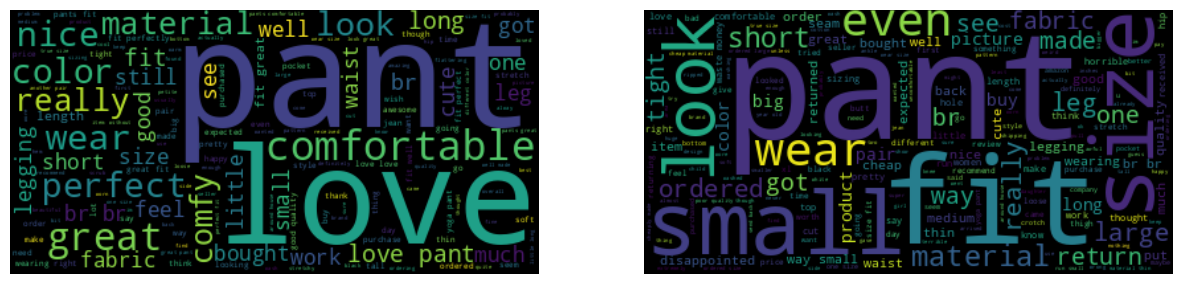

In [ ]:
# Create and generate a word cloud image:
pos_wordcloud = WordCloud().generate(pos_alltext)
neg_wordcloud = WordCloud().generate(neg_alltext)

# Display the generated image:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))

plt.subplot(1, 2, 1)
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()
#plt.tight_layout()


From the word cloud, these words came up frequently for both positive and negative reviews:

*  material
*  fabric

in the word cloud for positive / high reviews

* comfortable
* color
* waist
* legging